In [133]:
import numpy as np
import matplotlib.pyplot as plt
import json
import statistics
import re
import datetime
import scipy.stats as stats

In [134]:
def read_pods_file(file_path):
    
    running_pods = []
    with open(file_path, 'r') as file:
        intervals = file.read().split("#####")
        pods_in_intervals = [interval.strip().split("\n") for interval in intervals]
        for pods in pods_in_intervals:
            action_pods = [pod for pod in pods if "float" in pod]
            running_pods.append(len(action_pods))
    
    return statistics.mean(running_pods)

In [135]:
def read_activation_file(file_path):
    activations = []

    # Open the file in read mode
    with open(file_path, 'r') as file:
        # Read each line (assuming each line contains a JSON object)
        for line in file:
            activ = json.loads(line.strip())
            activations.append(activ)

    return activations

In [136]:
def read_timestamp_file(file_path):
    
    result = {}
    # Open the file in read mode
    with open(file_path, 'r') as file:
        for line in file:
            # Parse the JSON object
            k, v = line.strip().split(':')
            result[k.strip()] = v.strip()
    return result

    

In [137]:
def get_activation_values(activ):
    
#     print("ACTIV")
#     print(activ)
    start_time = int(activ['start'])/1000
    end_time = int(activ['end']) / 1000
    duration = int(activ['duration'])
    wait_time = int(activ['annotations'][1]['value'])
    activ_id = activ['activationId']
    
    # if init_annotation exists, then the function cold_started
    try:
        init_time = int(activ['annotations'][5]['value'])
        cold_start = True
    except:
        cold_start = False
    
    result_dict = {"cold_start": cold_start, "start_time": start_time, "end_time": end_time,
                  "duration": duration, "wait_time": wait_time}
    
    return {activ_id: result_dict}

def get_all_activation_values(activations):
    result = []
    for activ in activations:
        result.append(get_activation_values(activ))
    return result

In [138]:
def get_experiment_container_counts(activations, timestamps):
    
    exp_start = float(timestamps['Experiment_Start'])
    exp_end = float(timestamps['Experiment_End'])
    response_times = []
    cold_containers = []
    warm_containers = []
    interval = 1
    exp_time = int(exp_end - exp_start)
    ptr = exp_start
    end = exp_start + exp_time
    c = 0
    while(ptr < end):
        activ_during_interval = []
        cold_conts_in_interval = 0
        warm_conts_in_interval = 0
        for activ in activations:
            activ_id = list(activ.keys())[0]
            start_time = activ[activ_id]['start_time']
            end_time = activ[activ_id]['end_time']
            wait_time = activ[activ_id]['wait_time'] / 1000
            inflight_start_time = start_time - wait_time
            if (ptr >= inflight_start_time) and (ptr <= end_time):
                activ_during_interval.append(activ)     
        for activ in activ_during_interval:
            activ_id = list(activ.keys())[0]
            if activ[activ_id]['cold_start']:
                cold_conts_in_interval += 1
            else:
                warm_conts_in_interval += 1
        
        cold_containers.append(cold_conts_in_interval)
        warm_containers.append(warm_conts_in_interval)
        ptr += interval
        c += 1
    avg_warm_containers = np.mean(warm_containers)
    ci_warm_containers = stats.t.ppf(0.975, len(warm_containers)-1) * np.std(warm_containers)
    avg_cold_containers = np.mean(cold_containers)
    ci_cold_containers = stats.t.ppf(0.975, len(cold_containers)-1) * np.std(cold_containers)
    
    return avg_warm_containers, avg_cold_containers, ci_warm_containers, ci_cold_containers               

In [139]:
def get_experiment_response_time(activations):
    
    resp_times = []
    
    for activ in activations:
        activ_id = list(activ.keys())[0]
        resp_time = (activ[activ_id]["duration"] + activ[activ_id]["wait_time"])/1000
        resp_times.append(resp_time)
    
    avg_resp_time = np.mean(resp_times)
    ci_resp_time = stats.t.ppf(0.975, len(resp_times)-1) * np.std(resp_times)
    
    
    return avg_resp_time, ci_resp_time
    
    

In [140]:
def get_cold_start_prob(activations):
    
    num_requests = len(activations)
    num_cold_starts = 0
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]['cold_start']:
            num_cold_starts += 1
            
    return num_cold_starts/num_requests

In [159]:
def read_invoker_file(file_path):    
    messages = []
    with open(file_path, "r") as file:
        for line in file:
            messages.append(line.strip())
    
    return messages

def extract_timestamp(line):
    timestamp_pattern = r'\[(.*?)\]'
    timestamp_match = re.search(timestamp_pattern, line)
    if timestamp_match:
        return timestamp_match.group(1)
    else:
        return None

def timestamp_to_unix(timestamp_str):
    timestamp = datetime.datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    unix_timestamp_milliseconds = float(timestamp.timestamp())
    return unix_timestamp_milliseconds

def extract_tid(line):
    tid_pattern = r'\[#(.*?)\]'
    tid_match = re.search(tid_pattern, line)
    if tid_match:
        return tid_match.group(1)
    else:
        return None

                                      
def read_invoker_files(action_name, keep_alives):
    results = {}
    for ka in keep_alives:
        invoker_file_path = action_name + "_" + str(ka) + "/invoker.log"
        invocation_logs = read_invoker_file(invoker_file_path)
        results[ka] = invocation_logs
    
    return results

def get_unique_containers(invocation_logs, action_name):
    
    pattern = r'ContainerId\((.*?)\)'
    unique_containers = set()
    for log in invocation_logs:
        match = re.search(pattern, log)
        if match:
            container_id = match.group(1)
            unique_containers.add(container_id)
        else:
             continue
    action_containers = list(unique_containers)
    print("action_containers in regex", action_containers)
    action_containers = [cont for cont in action_containers if action_name in cont]
    return action_containers


def get_container_lifetimes(action_containers, invocation_logs):
    
    result = {}
    start_pattern = "invoker_kubeapi.create_start"
    delete_pattern = "invoker_kubeapi.delete_start"
    for cont in action_containers:
        container_logs = []
        result[cont] = {}
        for log in invocation_logs:
            if cont in log:
                container_logs.append(log)
        
        for log in container_logs:
            if start_pattern in log:
                result[cont]["start"] = timestamp_to_unix(extract_timestamp(log))
            elif delete_pattern in log:
                result[cont]["delete"] = timestamp_to_unix(extract_timestamp(log))
        #only start, delete pattern not found
        if len(result[cont].values()) == 1:    
            result[cont]["delete"] = float('inf')
    return result

def get_active_containers(activations, container_lifetimes, invocation_logs, experiment_duration):
    
    first_activ_id = list(activations[0].keys())[0]
    start_pattern = "activationId: " + first_activ_id
    start_timestamp = 0
    for log in invocation_logs:
        if start_pattern in log:
            start_timestamp = timestamp_to_unix(extract_timestamp(log))
    ptr = start_timestamp
    end_timestamp = start_timestamp + experiment_duration
    interval = 1
    active_containers = []
    #print("START", start_timestamp, "END", end_timestamp)
    while(ptr < end_timestamp):
        count = 0
        for cont, lifetime in container_lifetimes.items():
            if lifetime['start'] < ptr and lifetime['delete'] > ptr:
                count += 1
        active_containers.append(count)
        ptr += interval
    
    avg_active_containers = np.mean(active_containers)
    ci_active_containers = stats.t.ppf(0.975, len(active_containers)-1) * np.std(active_containers)
    
    return avg_active_containers, ci_active_containers

def get_active_containers_from_invocation_logs(activations, invocation_logs, timestamps, action_name):
    
    action_containers = get_unique_containers(invocation_logs, action_name)
    #print("action_containers", action_containers)
    container_lifetimes = get_container_lifetimes(action_containers, invocation_logs)
    #print("lifetimes", container_lifetimes)
    experiment_duration = int(float(timestamps["Experiment_End"]) - float(timestamps["Experiment_Start"]))
    
    return get_active_containers(activations, container_lifetimes, invocation_logs, experiment_duration)

def get_container_logs(action_containers, invocation_logs):
    
    all_container_logs = {}
    for cont in action_containers:
        container_logs = []
        for log in invocation_logs:
            if cont in log:
                container_logs.append(log)
        all_container_logs[cont] = container_logs
    return all_container_logs

def get_actual_keep_alives(all_container_logs, invocation_log):

    delete_pattern = 'invoker_kubeapi.delete_start'
    activation_finish_pattern = 'invoker_activationRun_finish'
    keep_alive_times = []
    for cont, logs in all_container_logs.items():
        if delete_pattern in logs[-1]:
            #print(logs[-1])
            delete_timestamp = timestamp_to_unix(extract_timestamp(logs[-1]))
            tid_last_func = extract_tid(logs[-2])
            last_func_logs = [log for log in invocation_log if tid_last_func in log]
            activ_finish_log = [log for log in last_func_logs if activation_finish_pattern in log]
            idle_start_timestamp = timestamp_to_unix(extract_timestamp(activ_finish_log[0])) 
            keep_alive_times.append(delete_timestamp - idle_start_timestamp)
        else:
            continue
    return statistics.mean(keep_alive_times), statistics.stdev(keep_alive_times) 
    
    
            

In [160]:
## Parse experiment files
def parse_files(action_name, keep_alives):
    results = {}
    for ka in keep_alives:
        ka_in_ow = ka 
        activation_file_path = action_name + "_" + str(ka_in_ow) + "/activation.log"
        timestamp_file_path = action_name + "_" + str(ka_in_ow) + "/timestamp.log"
        pods_file_path = action_name + "_" + str(ka_in_ow) + "/pods.log"
        invoker_file_path = action_name + "_" + str(ka_in_ow) + "/invoker.log"
        activations = read_activation_file(activation_file_path)
        timestamps = read_timestamp_file(timestamp_file_path)
        #running_containers = read_pods_file(pods_file_path)
        invocation_logs = read_invoker_file(invoker_file_path)
        #results[ka] = activations, timestamps, running_containers
        results[ka] = activations, timestamps, invocation_logs
    return results
        
        
        
        

In [161]:
def get_distributions(results, action_name):
    
    warm_containers = {}
    cold_containers = {}
    idle_containers = {}
    response_times = {}
    active_containers = {}
    cold_start_probs = {}
    ci_response_times = {}
    ci_warm_containers = {}
    ci_cold_containers = {}
    ci_active_containers = {}
    #avg_active_containers = {}
    #running_containers = {}
        
    for ka in results:
        activations = get_all_activation_values(results[ka][0])
        timestamps = results[ka][1]
        invocation_logs = results[ka][2]
        avg_warm_containers, avg_cold_containers, ci_warm_container, ci_cold_container = get_experiment_container_counts(activations, timestamps)
        avg_response_time, ci_response_time = get_experiment_response_time(activations)
        #active_containers[ka] = results[ka][2]
        avg_active_containers, ci_active_container = get_active_containers_from_invocation_logs(activations, invocation_logs, timestamps, action_name)
        warm_containers[ka] = avg_warm_containers
        cold_containers[ka] = avg_cold_containers
        active_containers[ka] = avg_active_containers
        idle_containers[ka] = active_containers[ka] - avg_warm_containers - avg_cold_containers
        response_times[ka] = avg_response_time
        cold_start_probs[ka] = get_cold_start_prob(activations)
        ci_response_times[ka] = ci_response_time
        ci_warm_containers[ka] = ci_warm_container
        ci_cold_containers[ka] = ci_cold_container
        ci_active_containers[ka] = ci_active_container
        print("ACTIVE", avg_active_containers)
        
    return (warm_containers, cold_containers, active_containers, idle_containers, response_times, 
            cold_start_probs, ci_response_times, ci_warm_containers, ci_cold_containers, ci_active_containers)
    #return warm_containers, cold_containers, running_containers, idle_containers, response_times

In [162]:
keep_alives = [1, 3, 5, 7, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 35, 40, 45, 50, 55, 60, 75, 90, 120, 150]
#keep_alives = list(map(lambda ka: ka + 2, keep_alives))
#keep_alives = [5, 30]
action_name = "image-thumbnail"
results = parse_files(action_name, keep_alives)

In [163]:
exp_warm_containers, exp_cold_containers, exp_running_containers, exp_idle_containers, exp_response_times, exp_cold_start_probs, ci_response_times, ci_warm_containers, ci_cold_containers, ci_active_containers = get_distributions(results, action_name)

action_containers in regex ['wskowdev-invoker-00-241-guest-imagethumbnail', 'wskowdev-invoker-00-291-guest-imagethumbnail', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-292-guest-imagethumbnail', 'wskowdev-invoker-00-628-guest-imagethumbnail', 'wskowdev-invoker-00-735-guest-imagethumbnail', 'wskowdev-invoker-00-423-guest-imagethumbnail', 'wskowdev-invoker-00-74-guest-imagethumbnail', 'wskowdev-invoker-00-484-guest-imagethumbnail', 'wskowdev-invoker-00-430-guest-imagethumbnail', 'wskowdev-invoker-00-142-guest-imagethumbnail', 'wskowdev-invoker-00-775-guest-imagethumbnail', 'wskowdev-invoker-00-175-guest-imagethumbnail', 'wskowdev-invoker-00-330-guest-imagethumbnail', 'wskowdev-invoker-00-491-guest-imagethumbnail', 'wskowdev-invoker-00-464-guest-imagethumbnail', 'wskowdev-invoker-00-325-guest-imagethumbnail', 'wskowdev-invoker-00-662-guest-imagethumbnail', 'wskowdev-invoker-00-5-guest-imagethumbnail', 'wskowdev-invoker-00-373-guest-imagethumbnail', 'wskowdev-invoke

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-189-guest-imagethumbnail', 'wskowdev-invoker-00-241-guest-imagethumbnail', 'wskowdev-invoker-00-291-guest-imagethumbnail', 'wskowdev-invoker-00-167-guest-imagethumbnail', 'wskowdev-invoker-00-135-guest-imagethumbnail', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-154-guest-imagethumbnail', 'wskowdev-invoker-00-248-guest-imagethumbnail', 'wskowdev-invoker-00-292-guest-imagethumbnail', 'wskowdev-invoker-00-101-guest-imagethumbnail', 'wskowdev-invoker-00-209-guest-imagethumbnail', 'wskowdev-invoker-00-232-guest-imagethumbnail', 'wskowdev-invoker-00-74-guest-imagethumbnail', 'wskowdev-invoker-00-185-guest-imagethumbnail', 'wskowdev-invoker-00-214-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-53-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-142-guest-imagethumbnail', 'wskowdev-invoker-

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-167-guest-imagethumbnail', 'wskowdev-invoker-00-135-guest-imagethumbnail', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-154-guest-imagethumbnail', 'wskowdev-invoker-00-101-guest-imagethumbnail', 'wskowdev-invoker-00-74-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-53-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-142-guest-imagethumbnail', 'wskowdev-invoker-00-23-guest-imagethumbnail', 'wskowdev-invoker-00-67-guest-imagethumbnail', 'wskowdev-invoker-00-16-guest-imagethumbnail', 'wskowdev-invoker-00-143-guest-imagethumbnail', 'wskowdev-invoker-00-66-guest-imagethumbnail', 'wskowdev-invoker-00-137-guest-imagethumbnail', 'wskowdev-invoker-00-175-guest-imagethumbnail', 'wskowdev-invoker-00-102-guest-imagethumbnail', 'wskowdev-invoker-00-5-guest-imagethumbnail', 'wskowdev-invoker-00-91-

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-101-guest-imagethumbnail', 'wskowdev-invoker-00-74-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-53-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-23-guest-imagethumbnail', 'wskowdev-invoker-00-67-guest-imagethumbnail', 'wskowdev-invoker-00-16-guest-imagethumbnail', 'wskowdev-invoker-00-66-guest-imagethumbnail', 'wskowdev-invoker-00-102-guest-imagethumbnail', 'wskowdev-invoker-00-5-guest-imagethumbnail', 'wskowdev-invoker-00-91-guest-imagethumbnail', 'wskowdev-invoker-00-133-guest-imagethumbnail', 'wskowdev-invoker-00-98-guest-imagethumbnail', 'wskowdev-invoker-00-62-guest-imagethumbnail', 'wskowdev-invoker-00-131-guest-imagethumbnail', 'wskowdev-invoker-00-18-guest-imagethumbnail', 'wskowdev-invoker-00-15-guest-imagethumbnail', 'wskowdev-invoker-00-2-prewar

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-61-guest-imagethumbnail', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-34-guest-imagethumbnail', 'wskowdev-invoker-00-37-guest-imagethumbnail', 'wskowdev-invoker-00-40-guest-imagethumbnail', 'wskowdev-invoker-00-29-guest-imagethumbnail', 'wskowdev-invoker-00-59-guest-imagethumbnail', 'wskowdev-invoker-00-27-guest-imagethumbnail', 'wskowdev-invoker-00-14-guest-imagethumbnail', 'wskowdev-invoker-00-47-guest-imagethumbnail', 'wskowdev-invoker-00-52-guest-imagethumbnail', 'wskowdev-invoker-00-41-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-12-guest-imagethumbnail', 'wskowdev-invoker-00-23-guest-imagethumbnail', 'wskowdev-invoker-00-43-guest-imagethumbnail', 'wskowdev-invoker-00-16-guest-imagethumbnail', 'wskowdev-invoker-00-30-guest-imagethumbnail', 'wskowdev-invoker-00-51-guest-im

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-25-guest-imagethumbnail', 'wskowdev-invoker-00-34-guest-imagethumbnail', 'wskowdev-invoker-00-37-guest-imagethumbnail', 'wskowdev-invoker-00-40-guest-imagethumbnail', 'wskowdev-invoker-00-29-guest-imagethumbnail', 'wskowdev-invoker-00-27-guest-imagethumbnail', 'wskowdev-invoker-00-14-guest-imagethumbnail', 'wskowdev-invoker-00-47-guest-imagethumbnail', 'wskowdev-invoker-00-52-guest-imagethumbnail', 'wskowdev-invoker-00-41-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-53-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-12-guest-imagethumbnail', 'wskowdev-invoker-00-23-guest-imagethumbnail', 'wskowdev-invoker-00-43-guest-imagethumbnail', 'wskowdev-invoker-00-16-guest-imagethumbnail', 'wskowdev-invoker-00-30-guest-imagethumbnail', 'wskowdev-invoker-00-51-guest-im

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-16-prewarm-nodejs14', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-25-guest-imagethumbnail', 'wskowdev-invoker-00-29-guest-imagethumbnail', 'wskowdev-invoker-00-27-guest-imagethumbnail', 'wskowdev-invoker-00-14-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-12-guest-imagethumbnail', 'wskowdev-invoker-00-23-guest-imagethumbnail', 'wskowdev-invoker-00-30-guest-imagethumbnail', 'wskowdev-invoker-00-22-guest-imagethumbnail', 'wskowdev-invoker-00-5-guest-imagethumbnail', 'wskowdev-invoker-00-8-guest-imagethumbnail', 'wskowdev-invoker-00-18-guest-imagethumbnail', 'wskowdev-invoker-00-1-prewarm-nodejs14', 'wskowdev-invoker-00-13-guest-imagethumbnail', 'wskowdev-invoker-00-15-guest-imagethumbnail', 'wskowdev-invoker-00-2-prewarm-nodejs14', 'wskowdev-invoker-00-3-whisksystem-invokerhealth

action_containers in regex ['wskowdev-invoker-00-11-guest-imagethumbnail', 'wskowdev-invoker-00-16-prewarm-nodejs14', 'wskowdev-invoker-00-19-guest-imagethumbnail', 'wskowdev-invoker-00-25-guest-imagethumbnail', 'wskowdev-invoker-00-29-guest-imagethumbnail', 'wskowdev-invoker-00-27-guest-imagethumbnail', 'wskowdev-invoker-00-14-guest-imagethumbnail', 'wskowdev-invoker-00-33-guest-imagethumbnail', 'wskowdev-invoker-00-32-guest-imagethumbnail', 'wskowdev-invoker-00-12-guest-imagethumbnail', 'wskowdev-invoker-00-23-guest-imagethumbnail', 'wskowdev-invoker-00-30-guest-imagethumbnail', 'wskowdev-invoker-00-22-guest-imagethumbnail', 'wskowdev-invoker-00-5-guest-imagethumbnail', 'wskowdev-invoker-00-8-guest-imagethumbnail', 'wskowdev-invoker-00-18-guest-imagethumbnail', 'wskowdev-invoker-00-1-prewarm-nodejs14', 'wskowdev-invoker-00-13-guest-imagethumbnail', 'wskowdev-invoker-00-15-guest-imagethumbnail', 'wskowdev-invoker-00-2-prewarm-nodejs14', 'wskowdev-invoker-00-3-whisksystem-invokerhealth

In [130]:
exp_response_times

{1: 2.0487491666666666,
 3: 0.8500616666666666,
 5: 0.5056808333333334,
 7: 0.4404625,
 10: 0.32744,
 12: 0.3109458333333333,
 14: 0.29635,
 16: 0.28564083333333334,
 18: 0.28821250000000004,
 20: 0.2554983333333333,
 22: 0.26144000000000006,
 24: 0.2578025,
 26: 0.2524533333333333,
 28: 0.2401316666666667,
 30: 0.24492916666666664,
 35: 0.23842083333333336,
 40: 0.2361825,
 45: 0.2421566666666667,
 50: 0.22992333333333334,
 55: 0.2403175,
 60: 0.23188666666666669,
 75: 0.22131583333333335,
 90: 0.21768916666666666,
 120: 0.20517000000000002,
 150: 0.20099333333333333}

In [131]:
#Container FaaS Model
from scipy.stats import expon
import numpy as np
from math import factorial, inf, exp


def ErlangB(Rho, m):
    """ErlangB calculates the blocking probability for a M/G/m/m loss system.
    The probability returned is in range [0-1].
    It is easy to prove the correctness of the value.

    Source1: https://en.wikipedia.org/wiki/Erlang_%28unit%29#Erlang_B_formula

    Source2: https://stackoverflow.com/questions/23528145/how-to-wtite-erlang-b-and-erlang-c-formulas-in-python

    :param Rho: Rho = lambda/mu
    :type Rho: double
    :param m: The number of servers.
    :type m: int
    :return: The blocking probability for incoming requests.
    :rtype: double
    """
    InvB = 1.0
    for j in range(1, m+1):
        InvB = 1.0 + InvB * (j/Rho)
    return (1.0 / InvB)


def print_props(props):
    print("\nProperties:")
    print("------------------")
    for k in props.keys():
        print(f"{k}: {props[k]:4.6f}")
    print("------------------\n")


def get_sls_warm_count_dist(arrival_rate, warm_service_time, cold_service_time, idle_time_before_kill, maximum_concurrency=1000, faster_solution=True):
    warm_service_rate = 1 / warm_service_time
    cold_service_rate = 1 / cold_service_time
    rho = arrival_rate / warm_service_rate

    server_max = maximum_concurrency
    if faster_solution:
        server_max = min(30, maximum_concurrency)
    server_count = 0

    pblock_old = 1
    kill_rate = 0

    server_counts = [0]
    block_rates = [arrival_rate]
    kill_rates = [0.0]
    cold_probs = [1]
    running_counts = [arrival_rate * 1 * cold_service_time]
    running_warm_counts = [0]
    running_cold_counts = [running_counts[0]]
    resp_times = [cold_service_time]


    while server_count < server_max:
        server_count += 1

        # The blocking probability, the blocked requests are cold starts.
        prob_block = ErlangB(rho, server_count)
        block_rate = prob_block * arrival_rate

        # The difference between blocked requests in m-1 and m is the requests
        # served on the m'th servers.
        prob_mth_server = pblock_old - prob_block
        pblock_old = prob_block

        # prob of no request in the next idle_time_before_kill for each request
        prob_kill_mth = 1 - \
            expon.cdf(idle_time_before_kill, scale=1 /
                      (arrival_rate * prob_mth_server))
        if prob_kill_mth > 0:
            # expected number of requests before the last one
            exp_request_before_kill = 1 / prob_kill_mth

            L = arrival_rate * prob_mth_server
            T = idle_time_before_kill + warm_service_time
            # average time between requests, when those requests wouldn't
            # be so far apart that results in killing the container.
#             avg_inter_arrival = (-1 * T * exp(-1 * L * T)) + \
#                 (1 - exp(-1 * L * T)) / L
            
            avg_inter_arrival = 1/L

            # Time it takes for a container to be killed after being created.
            inter_kill_time = idle_time_before_kill + \
                (exp_request_before_kill - 1) * avg_inter_arrival
            kill_rate += 1 / inter_kill_time
        else:
            kill_rate += 0

        # Average number of warm containers serving the requests
        running_count_warm = arrival_rate * \
            (1 - prob_block) * warm_service_time
        running_count_cold = arrival_rate * prob_block * cold_service_time
        running_count = running_count_warm + running_count_cold

        # Average Response Time
        resp_time = (prob_block * cold_service_time) + \
            ((1 - prob_block) * warm_service_time)

        # If we reached maximum concurrency, we don't have cold starts any more!
        if server_count == maximum_concurrency:
            resp_time = warm_service_time
            running_count_cold = 0
            running_count = running_count_warm

        # Record properties for each state in CTMC
        server_counts.append(server_count)
        block_rates.append(block_rate)
        kill_rates.append(kill_rate)
        cold_probs.append(prob_block)
        running_counts.append(running_count)
        resp_times.append(resp_time)
        running_warm_counts.append(running_count_warm)
        running_cold_counts.append(running_count_cold)

        if faster_solution:
            if block_rate > kill_rate:
                server_max = min(server_count + 30, maximum_concurrency)

    server_counts = np.array(server_counts)
    block_rates = np.array(block_rates)
    kill_rates = np.array(kill_rates)
    cold_probs = np.array(cold_probs)
    running_counts = np.array(running_counts)
    resp_times = np.array(resp_times)
    running_warm_counts = np.array(running_warm_counts)
    running_cold_counts = np.array(running_cold_counts)

    states_counts = len(server_counts)
    Q = np.zeros((states_counts, states_counts))
    for i in range(states_counts):
        out_rate = 0
        if i > 0:
            Q[i, i-1] = kill_rates[i]
            out_rate += kill_rates[i]
        if i < states_counts-1:
            Q[i, i+1] = (block_rates[i] * cold_service_rate) / (block_rates[i] + cold_service_rate)
            out_rate += (block_rates[i] * cold_service_rate) / (block_rates[i] + cold_service_rate)
        Q[i, i] = 0 - out_rate

    Q[:, 0] = 1
    y = np.zeros((1, Q.shape[0]))
    y[0, 0] = 1

    solution = np.linalg.solve(np.array(Q.T), np.array(y.T))
    solution = solution.reshape(solution.shape[0],)
    solution[solution < 0] = 0

    # if hasn't reached maximum concurrency, we can't measure it via float (accuracy is not enough, out guess is zero)
    rejection_prob = 0
    rejection_rate = 0
    # when we reach maximum concurrency, cold starts can't happen, so they are rejections
    if server_max == maximum_concurrency:
        rejection_prob = cold_probs[-1] * solution[-1]
        cold_probs[-1] = 0
        rejection_rate = block_rates[-1] * solution[-1]
        block_rates[-1] = 0

    avg_server_count = np.dot(server_counts, solution)
    avg_running_count = np.dot(running_counts, solution)
    avg_running_warm_count = np.dot(running_warm_counts, solution)
    avg_running_cold_count = np.dot(running_cold_counts, solution)
    avg_server_count_total = avg_server_count + avg_running_cold_count # total count is average of warm + average of running cold
    avg_resp_time = np.dot(resp_times, solution)
    avg_idle_count = avg_server_count - avg_running_warm_count
    cold_prob = np.dot(cold_probs, solution)
    avg_utilization = avg_running_warm_count / avg_server_count

    return {
        "avg_server_count": avg_server_count,
        "avg_server_count_total": avg_server_count_total,
        "avg_running_count": avg_running_count,
        "avg_running_warm_count": avg_running_warm_count,
        "avg_running_cold_count": avg_running_cold_count,
        "avg_idle_count": avg_idle_count,
        "cold_prob": cold_prob,
        "avg_utilization": avg_utilization,
        "avg_resp_time": avg_resp_time,
        "rejection_prob": rejection_prob,
        "rejection_rate": rejection_rate,
    }

In [132]:
def gen_model_dists(arrival_rate, warm_service_time, cold_service_time, keep_alives):
    
    model_results = {}
    for ka in keep_alives:
        model_results[ka] = get_sls_warm_count_dist(arrival_rate, warm_service_time, cold_service_time, ka)
    return model_results

In [88]:
arrival_rate = 1
warm_service_time = 0.201
cold_service_time = 3.093
wa_model_resp_time = 0.0656
# spin_resp_std_dev = 0.9214
# spin_executors_std_dev = 2.6944
spin_exp_resp_time = 0.0624
spin_busy_executors = 0.0601
#ci_spin_busy_executors = stats.t.ppf(0.975, 1) * np.std(spin_executors_std_dev)
#ci_spin_resp_time = stats.t.ppf(0.975, 1) * np.std(spin_resp_std_dev)
wa_model_busy_executors = 0.153
model_results = gen_model_dists(arrival_rate, warm_service_time, cold_service_time, keep_alives)

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use("seaborn-whitegrid")


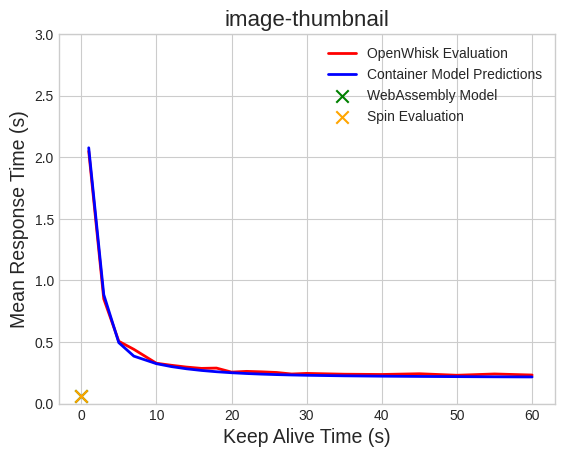

In [97]:
#plt.figure(figsize=(10, 6))
model_resp_times = [model['avg_resp_time'] for model in list(model_results.values())]
exp_resp_times = np.array(list(exp_response_times.values()))
exp_ci_resp_times = np.array(list(ci_response_times.values()))



plt.plot(keep_alives[:-4], exp_resp_times[:-4], color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives[:-4], model_resp_times[:-4], color='blue', label="Container Model Predictions", linewidth=2)
plt.xlabel('Keep Alive Time (s)', fontsize=14)
plt.ylabel('Mean Response Time (s)', fontsize=14)
plt.scatter(0, wa_model_resp_time, color='green', s=80, marker="x" , label='WebAssembly Model')
plt.scatter(0, spin_exp_resp_time, color='orange', s=80, marker="x",  label='Spin Evaluation')
#plt.fill_between(keep_alives[:-4], (exp_resp_times[:-4]-exp_ci_resp_times[:-4]), (exp_resp_times[:-4]+exp_ci_resp_times[:-4]), color='r', alpha=0.1)
#plt.errorbar(0, spin_exp_resp_time, yerr=ci_spin_resp_time, fmt='none', ecolor='orange', capsize=5)

plt.title(action_name, fontsize=16)
plt.ylim(0, 3)
#plt.xlim(0, 65)
plt.legend()
plt.savefig(f"figures/{action_name}_mean_response_time.png")

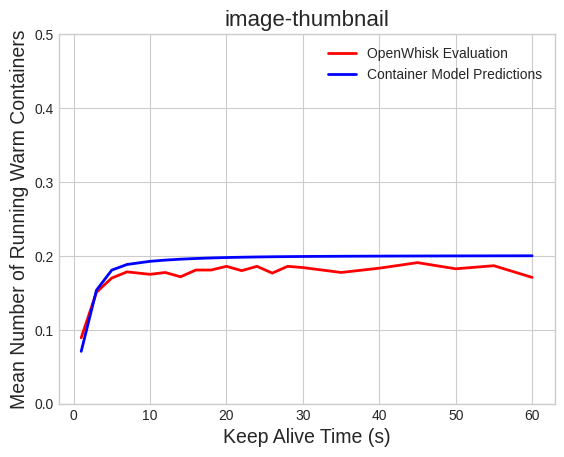

In [98]:
#plt.figure(figsize=(10, 6))

model_warm_conts = [model['avg_running_warm_count'] for model in list(model_results.values())]
exp_warm_conts = np.array(list(exp_warm_containers.values()))
exp_ci_warm_conts = np.array(list(ci_warm_containers.values()))

plt.plot(keep_alives[:-4], exp_warm_conts[:-4], color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives[:-4], model_warm_conts[:-4], color='blue', label="Container Model Predictions", linewidth=2)

#plt.fill_between(keep_alives[:-4], (exp_warm_conts[:-4]-exp_ci_warm_conts[:-4]), (exp_warm_conts[:-4]+exp_ci_warm_conts[:-4]), color='r', alpha=0.1)
# plt.scatter(0, spin_busy_executors, color='orange', s=80, marker="x",  label='Spin Evaluation')
# plt.scatter(0, wa_model_busy_executors, color='green', s=80, marker="x" , label='WebAssembly Model')

plt.ylim(0, 0.5)
# Adding labels and title
plt.xlabel('Keep Alive Time (s)', fontsize=14)
plt.ylabel('Mean Number of Running Warm Containers', fontsize=14)
plt.title(action_name, fontsize=16)
plt.legend()
plt.savefig(f"figures/{action_name}_mean_warm_executors.png")

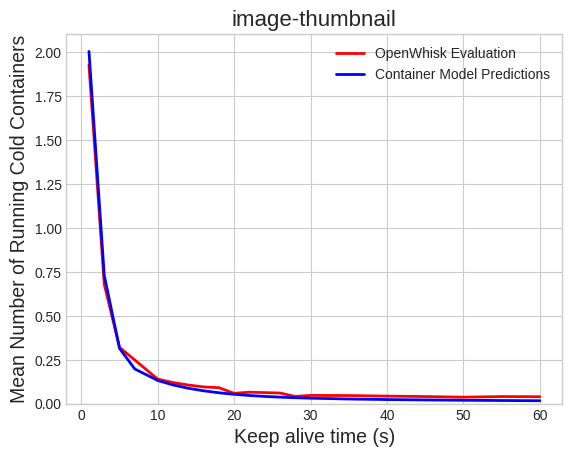

In [99]:
#plt.figure(figsize=(10, 6))

model_cold_conts = [model['avg_running_cold_count'] for model in list(model_results.values())]
exp_cold_conts = np.array(list(exp_cold_containers.values()))
exp_ci_cold_conts = np.array(list(ci_cold_containers.values()))

#plt.fill_between(keep_alives[:-4], (exp_cold_conts[:-4]-exp_ci_cold_conts[:-4]), (exp_cold_conts[:-4]+exp_ci_cold_conts[:-4]), color='r', alpha=0.1)
plt.plot(keep_alives[:-4], exp_cold_conts[:-4], color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives[:-4], model_cold_conts[:-4], color='blue', label="Container Model Predictions", linewidth=2)

# Adding labels and title
plt.xlabel('Keep_alive_time (s)')
plt.ylabel('Number of Cold Containers')
plt.title('Cold Container counts against keep alive threshold')

plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Mean Number of Running Cold Containers', fontsize=14)
plt.title(action_name, fontsize=16)

plt.ylim(0,)
plt.legend()
plt.savefig(f"figures/{action_name}_mean_cold_executors.png")

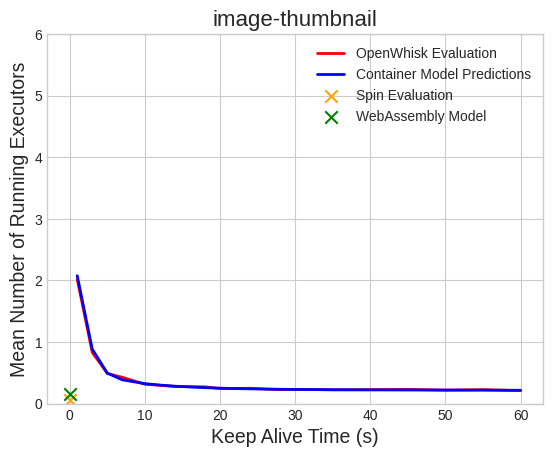

In [101]:
#plt.figure(figsize=(10, 6))

model_busy_conts = [model['avg_running_count'] for model in list(model_results.values())]
# exp_warm_conts = np.array(list(exp_warm_containers.values()))
# exp_ci_warm_conts = np.array(list(ci_warm_containers.values()))

plt.plot(keep_alives[:-4], exp_warm_conts[:-4] + exp_cold_conts[:-4] , color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives[:-4], model_busy_conts[:-4], color='blue', label="Container Model Predictions", linewidth=2)

#plt.fill_between(keep_alives[:-4], (exp_warm_conts[:-4]-exp_ci_warm_conts[:-4]), (exp_warm_conts[:-4]+exp_ci_warm_conts[:-4]), color='r', alpha=0.1)
plt.scatter(0, spin_busy_executors, color='orange', s=80, marker="x",  label='Spin Evaluation')
plt.scatter(0, wa_model_busy_executors, color='green', s=80, marker="x" , label='WebAssembly Model')

plt.ylim(0, 6)
# Adding labels and title
plt.xlabel('Keep Alive Time (s)', fontsize=14)
plt.ylabel('Mean Number of Running Executors', fontsize=14)
plt.title(action_name, fontsize=16)
plt.legend()
plt.savefig(f"figures/{action_name}_mean_busy_executors.png")

exp [-2.016652789342215, -0.8301415487094088, -0.48959200666111574, -0.42631140716069943, -0.3139050791007494, -0.29725228975853457, -0.27726894254787676, -0.2756036636136553, -0.2714404662781016, -0.24396336386344714, -0.24479600333055784, -0.24812656119900084, -0.23646960865945044, -0.22647793505412156, -0.23064113238967526, -0.22314737718567862, -0.22564529558701082, -0.23064113238967526, -0.21898417985012492, -0.22647793505412156, -0.20982514571190675, -0.2006661115736886, -0.2031640299750208, -0.19317235636969193, -0.18900915903413823]


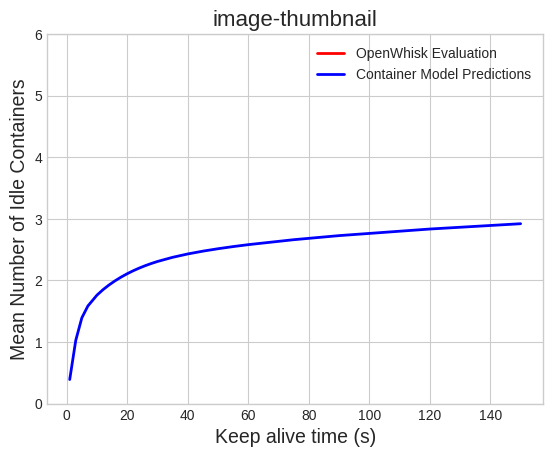

In [94]:
#plt.figure(figsize=(10, 6))

model_idle_conts = [model['avg_idle_count'] for model in list(model_results.values())]
exp_idle_conts = list(exp_idle_containers.values())
plt.plot(keep_alives, exp_idle_conts, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives, model_idle_conts, color='blue', label="Container Model Predictions", linewidth=2)

print("exp", exp_idle_conts)
# Adding labels and title
plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Mean Number of Idle Containers', fontsize=14)
plt.title(action_name, fontsize=16)
plt.ylim(0,6)
plt.legend()
plt.savefig(f"figures/{action_name}_mean_idle_executors.png")

total [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


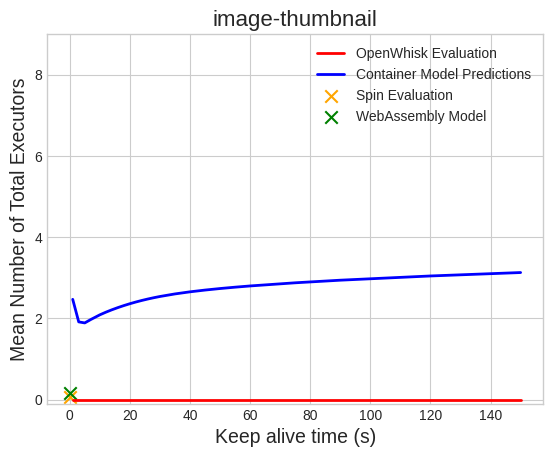

In [102]:
#plt.figure(figsize=(10, 6))

model_running_conts = [model['avg_server_count_total'] for model in list(model_results.values())]
exp_running_conts = np.array(list(exp_running_containers.values()))
exp_ci_active_conts = np.array(list(ci_active_containers.values()))

#plt.fill_between(keep_alives, (exp_running_conts-exp_ci_active_conts), (exp_running_conts+exp_ci_active_conts), color='r', alpha=0.1)


plt.plot(keep_alives, exp_running_conts, color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives, model_running_conts, color='blue', label="Container Model Predictions", linewidth=2)
plt.scatter(0, spin_busy_executors, color='orange', s=80, marker="x",  label='Spin Evaluation')
plt.scatter(0, wa_model_busy_executors, color='green', s=80, marker="x" , label='WebAssembly Model')


print("total", exp_running_conts)
# plt.plot(keep_alives, exp_running_conts, color='red', label="Experimental result")
# plt.plot(keep_alives, model_running_conts, color='blue', label="Model predictions")

# Adding labels and title
plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Mean Number of Total Executors', fontsize=14)
plt.title(action_name, fontsize=16)
plt.legend()
plt.ylim(-0.1 ,9)
plt.savefig(f"figures/{action_name}_mean_total_executors.png")

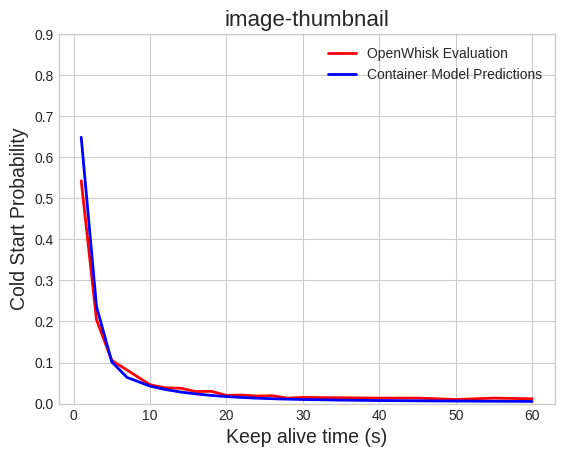

In [46]:
#plt.figure(figsize=(10, 6))

model_cold_probs = [model['cold_prob'] for model in list(model_results.values())]
exp_cold_probs = list(exp_cold_start_probs.values())
plt.plot(keep_alives[:-4], exp_cold_probs[:-4], color='red', label="OpenWhisk Evaluation", linewidth=2)
plt.plot(keep_alives[:-4], model_cold_probs[:-4], color='blue', label="Container Model Predictions", linewidth=2)

# Adding labels and title
plt.xlabel('Keep alive time (s)', fontsize=14)
plt.ylabel('Cold Start Probability', fontsize=14)
plt.title(action_name, fontsize=16)
plt.ylim(0, 0.9)
plt.legend()
plt.savefig(f"figures/{action_name}_cold_start_prob.png")

In [41]:
def get_warm_response_time(activations):
    
    resp_times = []
    
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]["cold_start"]:
            continue
        #print(activ)
        resp_time = (activ[activ_id]["duration"] + activ[activ_id]["wait_time"])/1000
        resp_times.append(resp_time)
        
    return statistics.mean(resp_times)

def get_cold_response_time(activations):
    
    resp_times = []
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]["cold_start"]:
            #print(activ)
            resp_time = (activ[activ_id]["duration"] + activ[activ_id]["wait_time"])/1000
            resp_times.append(resp_time)
    
    if resp_times:
        return statistics.mean(resp_times)
    else:
        return 0


def get_warm_cold_response_times(results):
    
    warm_response_times = {}
    cold_response_times = {}
    
    for ka in results.keys():
        activations = get_all_activation_values(results[ka][0])
        warm_response_times[ka] = get_warm_response_time(activations)
        cold_response_times[ka] = get_cold_response_time(activations)
    
    return warm_response_times, cold_response_times
    

In [42]:
def get_fire_dist(activations):
    
    fires = []
    sorted_activs = []
    for activ in activations:
        activ_id = list(activ.keys())[0]
        start_time = activ[activ_id]['start_time']
        wait_time = activ[activ_id]['wait_time'] / 1000
        inflight_start_time = start_time - wait_time
        sorted_activs.append(inflight_start_time)
        
    sorted_activs = sorted(sorted_activs)
    return sorted_activs

In [22]:
def get_num_cold_starts(activations):
    
    cold_starts = 0
    
    for activ in activations:
        activ_id = list(activ.keys())[0]
        if activ[activ_id]["cold_start"]:
            cold_starts += 1
    return cold_starts
        

In [23]:
def get_cold_start_probability(activations):
    
    num_cold_starts = get_num_cold_starts(activations)
    num_requests = len(activations)
    
    return num_cold_starts / num_requests
    

In [24]:
warm_response_times, cold_response_times = get_warm_cold_response_times(results)

In [25]:
cold_response_times

{1: 3.5988341013824883,
 3: 3.3726897959183675,
 5: 3.0944920634920634,
 7: 3.082357142857143,
 10: 2.962890909090909,
 12: 3.051239130434783,
 14: 2.8571555555555554,
 16: 3.172542857142857,
 18: 2.9963055555555553,
 20: 2.9262916666666667,
 22: 3.06528,
 24: 3.1947272727272726,
 26: 2.948,
 28: 2.9663125,
 30: 3.1517222222222223,
 35: 3.1171176470588233,
 40: 2.9850625,
 45: 2.999625,
 50: 3.2656666666666667,
 55: 2.84925,
 60: 3.233357142857143,
 75: 2.885666666666667,
 90: 3.105125,
 120: 3.2942,
 150: 3.139666666666667}

In [26]:
warm_response_times

{1: 0.2106703096539162,
 3: 0.20289528795811518,
 5: 0.2019655493482309,
 7: 0.2055208711433757,
 10: 0.20084628820960698,
 12: 0.20171403812824956,
 14: 0.196578354978355,
 16: 0.1989098712446352,
 18: 0.20445704467353953,
 20: 0.20099234693877552,
 22: 0.20178382978723405,
 24: 0.20295331069609507,
 26: 0.19977909940526764,
 28: 0.20329138513513514,
 30: 0.20066328257191202,
 35: 0.19705325443786983,
 40: 0.19903547297297297,
 45: 0.20489358108108108,
 50: 0.19925925925925925,
 55: 0.2050616554054054,
 60: 0.19645615514333895,
 75: 0.2011821998320739,
 90: 0.19831040268456376,
 120: 0.19224518828451884,
 150: 0.1936282372598162}

In [27]:
sum(cold_response_times.values())/len(cold_response_times)

3.0926231225184737

In [28]:
sum(warm_response_times.values())/len(warm_response_times)

0.20080585104933374

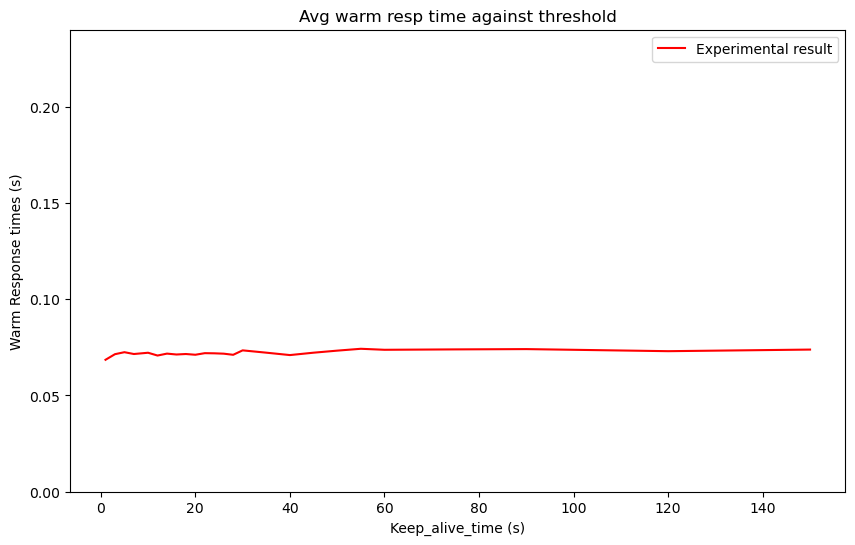

In [28]:
plt.figure(figsize=(10, 6))

exp_warm_resp_times = list(warm_response_times.values())
plt.plot(keep_alives, exp_warm_resp_times, color='red', label="Experimental result")

# Adding labels and title
plt.xlabel('Keep_alive_time (s)')
plt.ylabel('Warm Response times (s)')
plt.title('Avg warm resp time against threshold')
plt.ylim(0, 0.24)
plt.legend()

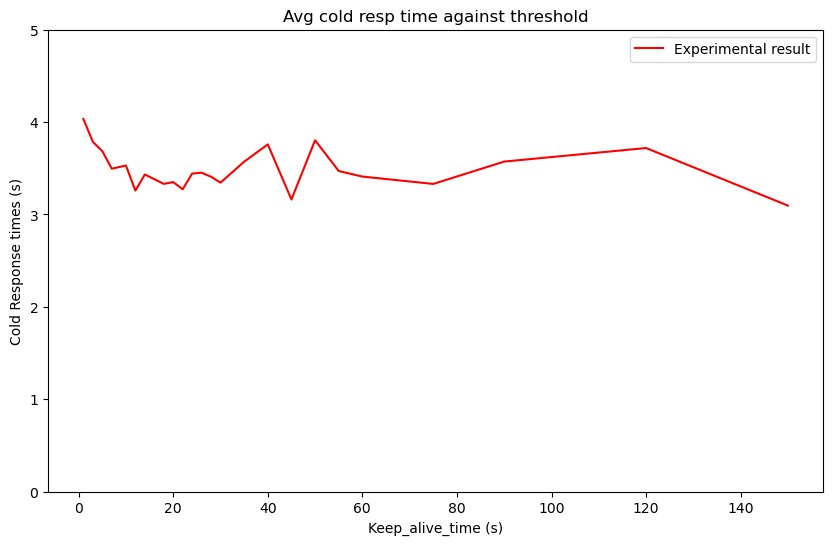

In [30]:
plt.figure(figsize=(10, 6))

exp_cold_resp_times = list(cold_response_times.values())
plt.plot(keep_alives, exp_cold_resp_times, color='red', label="Experimental result")

# Adding labels and title
plt.xlabel('Keep_alive_time (s)')
plt.ylabel('Cold Response times (s)')
plt.title('Avg cold resp time against threshold')
plt.ylim(0, 5)
plt.legend()

In [139]:
keep_alives

[3,
 5,
 7,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 75,
 90,
 120,
 150]

In [162]:
activs = read_activation_file("float_75/activation.log")
activs = get_all_activation_values(activs)

In [163]:
np.mean(np.diff(get_fire_dist(activs)))

1.0018857380466923

In [164]:
get_cold_response_time(activs)

4.226875

In [165]:
get_warm_response_time(activs)

1.563804054054054